# Getting started with mapclassify.greedy

Greedy or topological coloring (or sequential coloring) is a cartographic method of assigning colors to polygons (or other geometries, `mapclassify.greedy` supports all geometry types) in such a way, that no two adjacent polygons share the same color.

`greedy` is a small toolkit within `mapclassify` providing such a functionality on top of GeoPandas GeoDataFrames. `mapclassify.greedy()` is all we need.

In [1]:
from mapclassify import __version__, greedy

__version__

'2.9.1.dev9+gde74d6f.d20250614'

In [2]:
import geopandas
import seaborn

seaborn.set()

Few of `greedy`'s methods of coloring require either measuring of areas or distances. To obtain proper values, our GeoDataFrame needs to be in a projected CRS. Let's use Africa and reproject it to 'ESRI:102022':

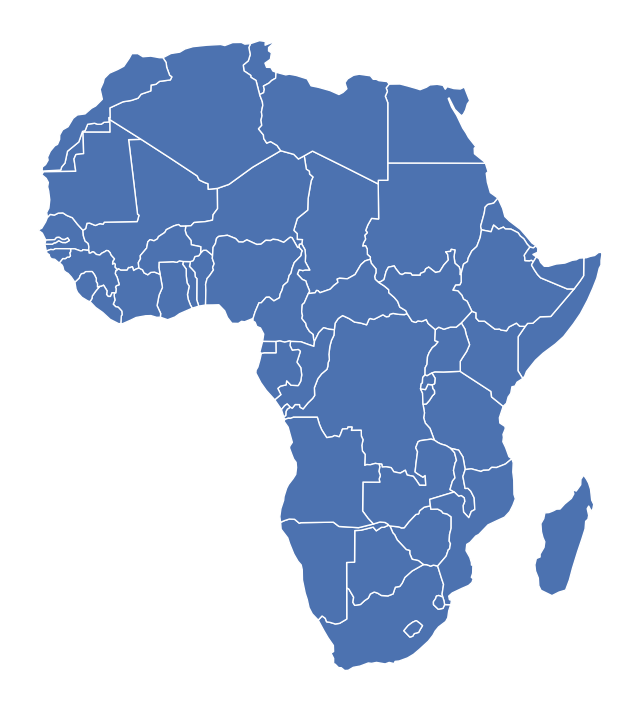

In [3]:
world = geopandas.read_file(
    "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
)
africa = world.loc[world.CONTINENT == "Africa"]
africa = africa.to_crs("ESRI:102022")
ax = africa.plot(figsize=(8, 12), edgecolor="w")
ax.set_axis_off()

## Default

The default usage of `greedy` is extremely simple. Greedy returns a Series with color codes, so we can assign it directly as a new column of our GeoDataFrame:

In [4]:
africa["greedy_default"] = greedy(africa)
africa["greedy_default"].head(5)

1     1
2     0
11    0
12    1
13    4
Name: greedy_default, dtype: int64

Using resulting color codes as plotting categories gives us following the plot:

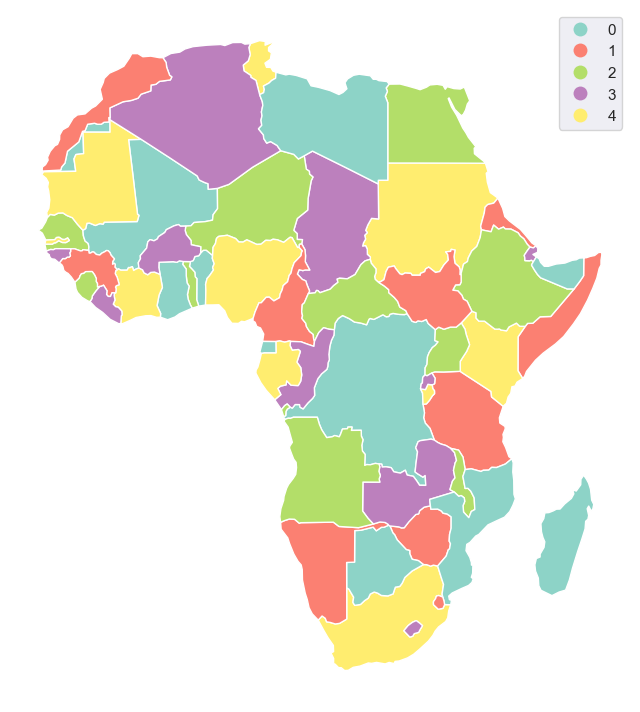

In [5]:
ax = africa.plot(
    figsize=(8, 12),
    column="greedy_default",
    categorical=True,
    cmap="Set3",
    legend=True,
    edgecolor="w",
)
ax.set_axis_off()

## Strategies

### Balanced

Greedy offers several strategies of coloring. The default strategy is `balanced` based on `count` attempting to balance the number of features per each color. Other balanced modes are `area` (balance the area covered by each color), `distance` and `centroid` (both attemtps to balance the distance between colors). Each of them attempt to balance the color assignment according to different conditions and hence can result in a different number of colors.

In [6]:
africa = africa.reset_index(drop=True)

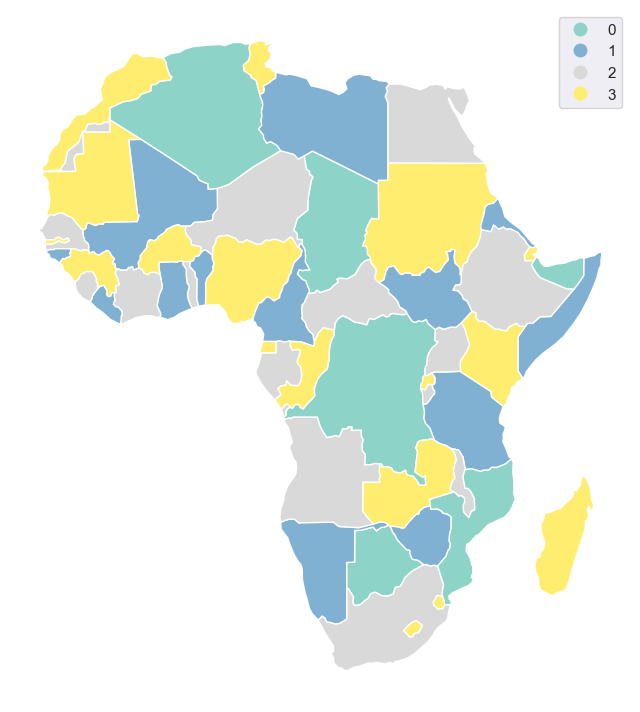

In [7]:
africa["greedy_area"] = greedy(africa, strategy="balanced", balance="area")
ax = africa.plot(
    "greedy_area",
    categorical=True,
    figsize=(8, 12),
    cmap="Set3",
    legend=True,
    edgecolor="w",
)
ax.set_axis_off()

Different modes of balancing within the `balanced` strategy can be set using the `balance` keyword.

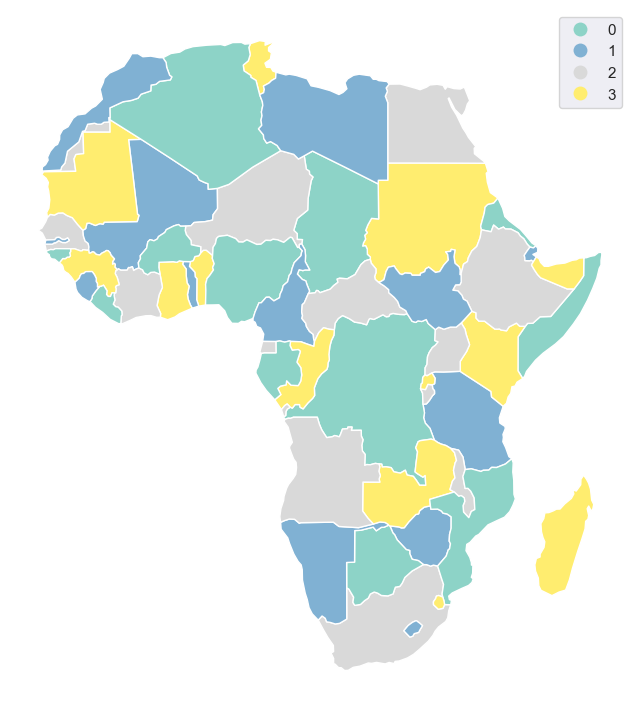

In [8]:
africa["greedy_distance"] = greedy(africa, strategy="balanced", balance="distance")
ax = africa.plot(
    "greedy_distance",
    categorical=True,
    figsize=(8, 12),
    cmap="Set3",
    legend=True,
    edgecolor="w",
)
ax.set_axis_off()

## NetworkX strategies

On top of four modes of balanced coloring strategy, `greedy` offers all `networkx.greedy_coloring()` strategies, like `largest_first`:

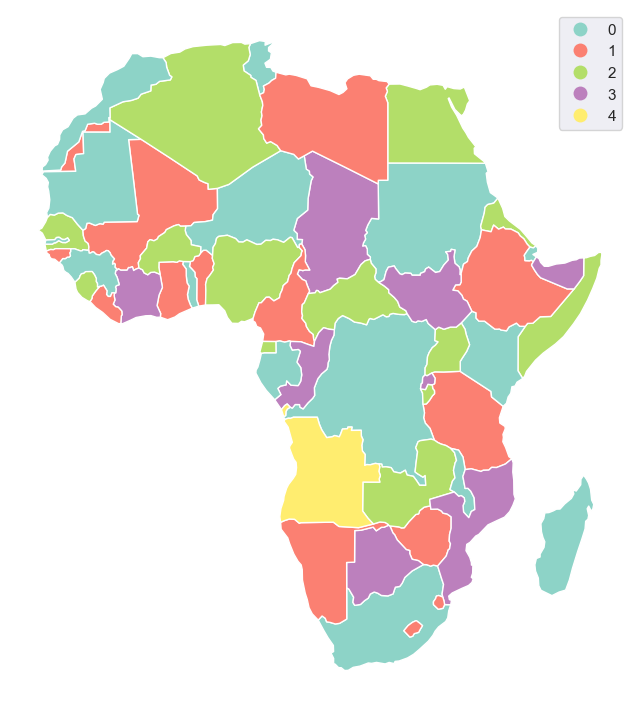

In [9]:
africa["greedy_largest_first"] = greedy(africa, strategy="largest_first")
ax = africa.plot(
    "greedy_largest_first",
    categorical=True,
    figsize=(8, 12),
    cmap="Set3",
    legend=True,
    edgecolor="w",
)
ax.set_axis_off()

Another strategy provided by NetworkX is `smallest_last`. All strategies provide different results. Check [Comparison of strategies](#Comparison-of-strategies) below for details.

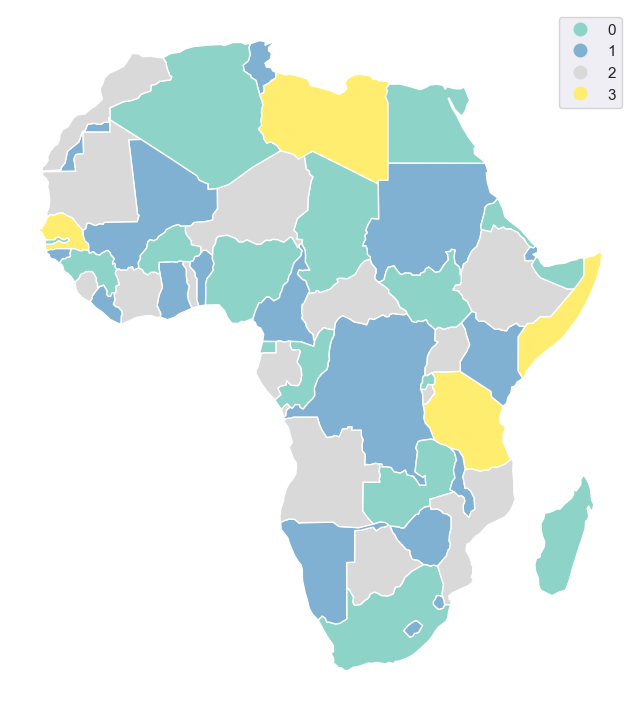

In [10]:
africa["greedy_s"] = greedy(africa, strategy="smallest_last")
ax = africa.plot(
    "greedy_s",
    categorical=True,
    figsize=(8, 12),
    cmap="Set3",
    legend=True,
    edgecolor="w",
)
ax.set_axis_off()

Greedy is variable in a way how to define adjacency and which coloring strategy to use. All options are described in this documentation together with comparison of their performance.

## Defining adjacency

The key in toplogical coloring is the definition of adjacency, to understand which features are neighboring and could not share the same color. `mapclassify.greedy` comes with several methods of defining it. Binary spatial weights denoting adjacency are then stored as `libpysal` weights objects.

In [11]:
from shapely.geometry import Point

For illustration purposes, let's generate a 10x10 mesh of square polygons:

In [12]:
def poly_lattice_gdf(dim, plot=False):
    polys = []
    for x in range(dim):
        for y in range(dim):
            polys.append(Point(x, y).buffer(0.5, cap_style=3))
    _gdf = geopandas.GeoDataFrame(geometry=polys)
    if plot:
        ax = _gdf.plot(edgecolor="w")
        ax.set_axis_off()
    return _gdf

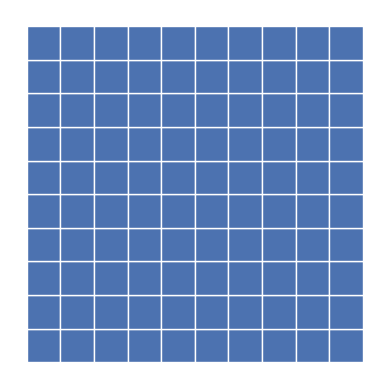

In [13]:
gdf = poly_lattice_gdf(10, plot=True)

### libpysal adjacency

The most performant way of generating spatial weights is using libpysal contiguity weights. As they are based on the shared nodes or edges, the dataset needs to be topologically correct. Neighboring polygons needs to share vertices and edges, otherwise their relationship will not be captured. There are two ways to define contiguity weights - `"rook"` and `"queen"`.

#### Rook

Rook identifies two objects as neighboring only if they share at least on edge - line between two shared points. Use rook if you do not mind two polygons touching by their corners having the same color:

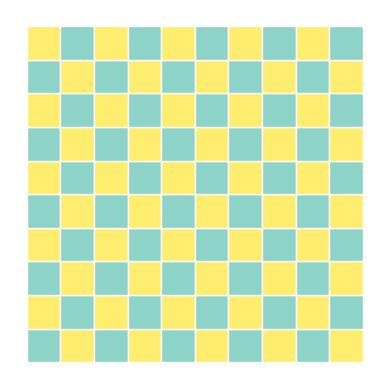

In [14]:
gdf["rook"] = greedy(gdf, sw="rook", min_colors=2)
ax = gdf.plot("rook", edgecolor="w", categorical=True, cmap="Set3")
ax.set_axis_off()

#### Queen

The default option in `greedy` is `"queen"` adjacency. Queen adjaceny identifies two objects as neighboring if they share at least one point. It ensures that even polygons sharing only one corner will not share a color:

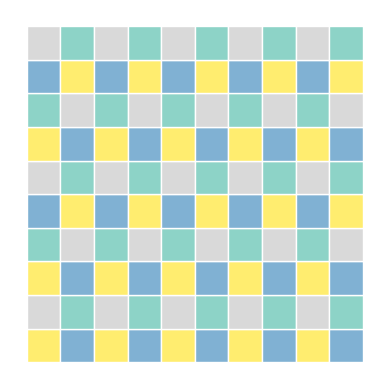

In [15]:
gdf["queen"] = greedy(gdf, sw="queen", min_colors=2)
ax = gdf.plot("queen", edgecolor="w", categorical=True, cmap="Set3")
ax.set_axis_off()

### Intersection-based adjacency

As noted above, if the topology of the dataset is not ideal, libpysal might not identify two visually neighboring features as neighbors. `greedy` can utilize an intersection-based algorithm using GEOS intersection to identify if two features intersects in any way. They do not have to share any points. Naturally, such an approach is significantly slower ([details below](#Performance)), but it can provide correct adjacency when libpysal fails.

To make `greedy` use this algorithm, one just needs to define `min_distance`. If it is set to 0, it behaves similarly to `queen` contiguity, just capturing all intersections:

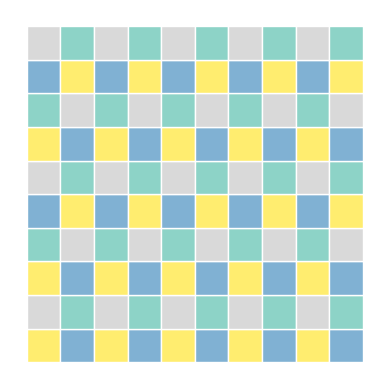

In [16]:
gdf["geos"] = greedy(gdf, min_distance=0, min_colors=2)
ax = gdf.plot("geos", edgecolor="w", categorical=True, cmap="Set3")
ax.set_axis_off()

`min_distance` also sets the minimal distance between colors. To do that, all features within such a distance are identified as neighbors, hence no two features within the set distance can share the same color:

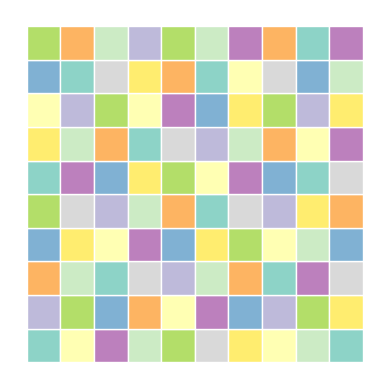

In [17]:
gdf["dist1"] = greedy(gdf, min_distance=1, min_colors=2)
ax = gdf.plot("dist1", edgecolor="w", categorical=True, cmap="Set3")
ax.set_axis_off()

### Reusing spatial weights

Passing `libpysal.weights.W` object to `sw`, will skip generating spatial weights and use the passed object instead. That will improve the performance if one intends to repeat the coloring multiple times. In that case, weights should be denoted using the GeodataFrame's index.

### Performance

The difference in performance of libpysal and GEOS-based method is large, so it is recommended to use libpysal if possible. Details of comparison between all methods are below:

In [18]:
import time

import numpy
import pandas

In [19]:
def run_greedy(_gdf, greedy_kws, min_colors=4, runs=5):
    timer = []
    for _ in range(runs):
        s = time.time()
        colors = greedy(_gdf, min_colors=min_colors, **greedy_kws)
        e = time.time() - s
        timer.append(e)
    _mean_time = round(numpy.mean(timer), 4)
    return _mean_time, colors


def printer(m, t, c):
    print(f"\t{m}:\t", t, "s;\t", c + 1, "colors")

In [20]:
params = {
    "rook": {"sw": "rook"},
    "queen": {"sw": "queen"},
    "geos": {"min_distance": 0},
    "dist1": {"min_distance": 1},
}

In [21]:
times = pandas.DataFrame(index=params.keys())
steps = range(10, 110, 10)
for step in steps:
    print(step, "----------------------------------------------")
    gdf = poly_lattice_gdf(step, plot=False)
    for method, kwargs in params.items():
        mean_time, colors = run_greedy(gdf, kwargs, min_colors=2)
        printer(method, mean_time, numpy.max(colors))
        times.loc[method, step] = mean_time

10 ----------------------------------------------
	rook:	 0.0017 s;	 2 colors
	queen:	 0.0016 s;	 4 colors
	geos:	 0.0012 s;	 4 colors
	dist1:	 0.0032 s;	 10 colors
20 ----------------------------------------------
	rook:	 0.006 s;	 2 colors
	queen:	 0.0057 s;	 4 colors
	geos:	 0.0036 s;	 4 colors
	dist1:	 0.0125 s;	 10 colors
30 ----------------------------------------------
	rook:	 0.0268 s;	 2 colors
	queen:	 0.0129 s;	 4 colors
	geos:	 0.0081 s;	 4 colors
	dist1:	 0.0294 s;	 10 colors
40 ----------------------------------------------
	rook:	 0.0243 s;	 2 colors
	queen:	 0.0237 s;	 4 colors
	geos:	 0.0158 s;	 4 colors
	dist1:	 0.0568 s;	 10 colors
50 ----------------------------------------------
	rook:	 0.0375 s;	 2 colors
	queen:	 0.0488 s;	 4 colors
	geos:	 0.0282 s;	 4 colors
	dist1:	 0.0975 s;	 10 colors
60 ----------------------------------------------
	rook:	 0.0664 s;	 2 colors
	queen:	 0.0526 s;	 4 colors
	geos:	 0.046 s;	 4 colors
	dist1:	 0.1666 s;	 10 colors
70 ---------

In [22]:
times

,10,20,30,40,50,60,70,80,90,100
rook,0.0017,0.0060,0.0268,0.0243,0.0375,0.0664,0.0861,0.1216,0.1475,0.1813
queen,0.0016,0.0057,0.0129,0.0237,0.0488,0.0526,0.0718,0.1078,0.1318,0.1736
geos,0.0012,0.0036,0.0081,0.0158,0.0282,0.0460,0.0837,0.1086,0.1560,0.2210
dist1,0.0032,0.0125,0.0294,0.0568,0.0975,0.1666,0.2378,0.3524,0.4902,0.6763


In [23]:
import matplotlib.pyplot as plt

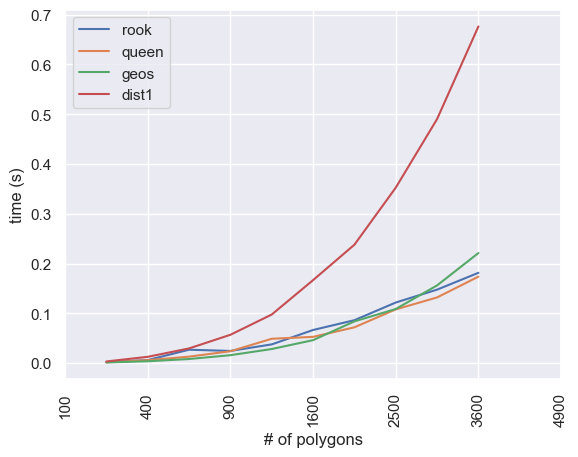

In [24]:
ax = times.T.plot()
ax.set_ylabel("time (s)")
ax.set_xlabel("# of polygons")
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels=(times.columns**2)[:7], rotation="vertical");

Plotting without the GEOS methods, the difference between `queen` and `rook` is minimal:

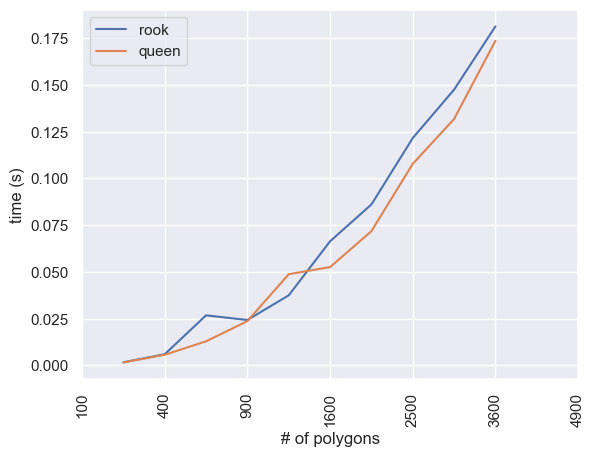

In [25]:
ax = times.loc[["rook", "queen"]].T.plot()
ax.set_ylabel("time (s)")
ax.set_xlabel("# of polygons")
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels=(times.columns**2)[:7], rotation="vertical");

## Comparison of strategies

Different coloring strategies lead to different results, but also have different performance. It all depends on the prefered goal. 

If one want visually balanced result, `'balanced'` strategy could be the right choice. It comes with four different modes of balancing - `'count'`, `'area'`, `'distance'`, and `'centroid'`. The first one attempts to balance the number of features per each color, the second balances the area covered by each color, and the two last are based on the distance between features (either represented by the geometry itself or its centroid, which is a bit faster).

Other strategies might be helpful if one wants to minimize the number of colors as not all strategies use the same amount in the end. Or they just might look better on your map.

In [26]:
strategies = [
    "balanced",
    "largest_first",
    "random_sequential",
    "smallest_last",
    "independent_set",
    "connected_sequential_bfs",
    "connected_sequential_dfs",
    "saturation_largest_first",
]
balanced_modes = ["count", "area", "centroid", "distance"]

In [27]:
import warnings

import libpysal

In [28]:
sw = libpysal.weights.Queen.from_dataframe(
    world, ids=world.index.to_list(), silence_warnings=True
)

Below is a comparison of performance and the result of each of the strategies supported by `greedy`.

When using the `'balanced'` strategy with `'area'`, `'distance'`, or `'centroid'` modes, keep in mind that your data needs to be in a projected CRS to obtain correct results. For the simplicity of this comparison, let's pretend that dataset below is (even though it is not).

Strategies used in `mapclassify.greedy` have two origins - `'balanced'` is ported from QGIS while the rest comes from NetworkX. The nippet below generates each option 20x and returns the mean time elapsed together with the number of colors used.

In [29]:
times = {}
with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore", message="Geometry is in a geographic CRS.", category=UserWarning
    )
    for strategy in strategies:
        if strategy == "balanced":
            for mode in balanced_modes:
                stgy_mode = strategy + "_" + mode
                print(stgy_mode)
                kwargs = {"strategy": strategy, "balance": mode, "sw": sw}
                mean_time, colors = run_greedy(world, kwargs, runs=20)
                printer("time", mean_time, numpy.max(colors))
                world[stgy_mode], times[stgy_mode] = colors, mean_time
        else:
            print(strategy)
            kwargs = {"strategy": strategy, "sw": sw}
            mean_time, colors = run_greedy(world, kwargs, runs=20)
            printer("time", mean_time, numpy.max(colors))
            world[strategy], times[strategy] = colors, mean_time

balanced_count
	time:	 0.0004 s;	 5 colors
balanced_area
	time:	 0.0095 s;	 5 colors
balanced_centroid
	time:	 1.3561 s;	 5 colors
balanced_distance
	time:	 1.3759 s;	 5 colors
largest_first
	time:	 0.0006 s;	 5 colors
random_sequential
	time:	 0.0005 s;	 5 colors
smallest_last
	time:	 0.0011 s;	 4 colors
independent_set
	time:	 0.0275 s;	 5 colors
connected_sequential_bfs
	time:	 0.0009 s;	 5 colors
connected_sequential_dfs
	time:	 0.0009 s;	 5 colors
saturation_largest_first
	time:	 0.0096 s;	 4 colors


As you can see, `smallest_last` and `saturation_largest_first` were able, for this particular dataset, to generate greedy coloring using only 4 colors. If one wants to use a higher number than the minimal, the `'balanced'` strategy allows the setting of `min_colors`.

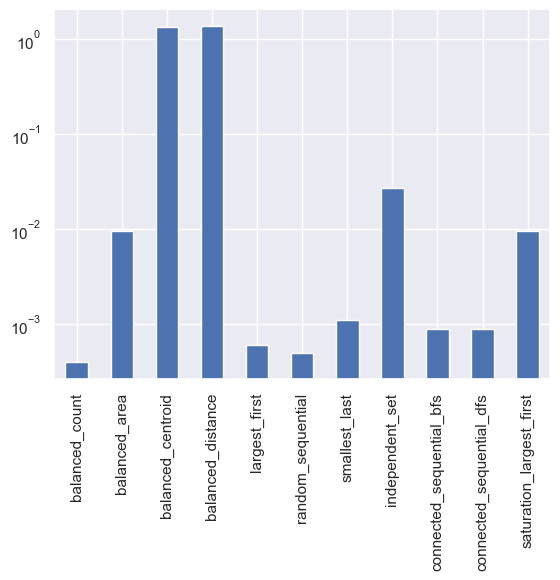

In [30]:
times = pandas.Series(times)
ax = times.plot(kind="bar")
ax.set_yscale("log")

The plot above shows the performance of each strategy. Note that the vertical axis is using log scale.

Below are all results plotted on the map.

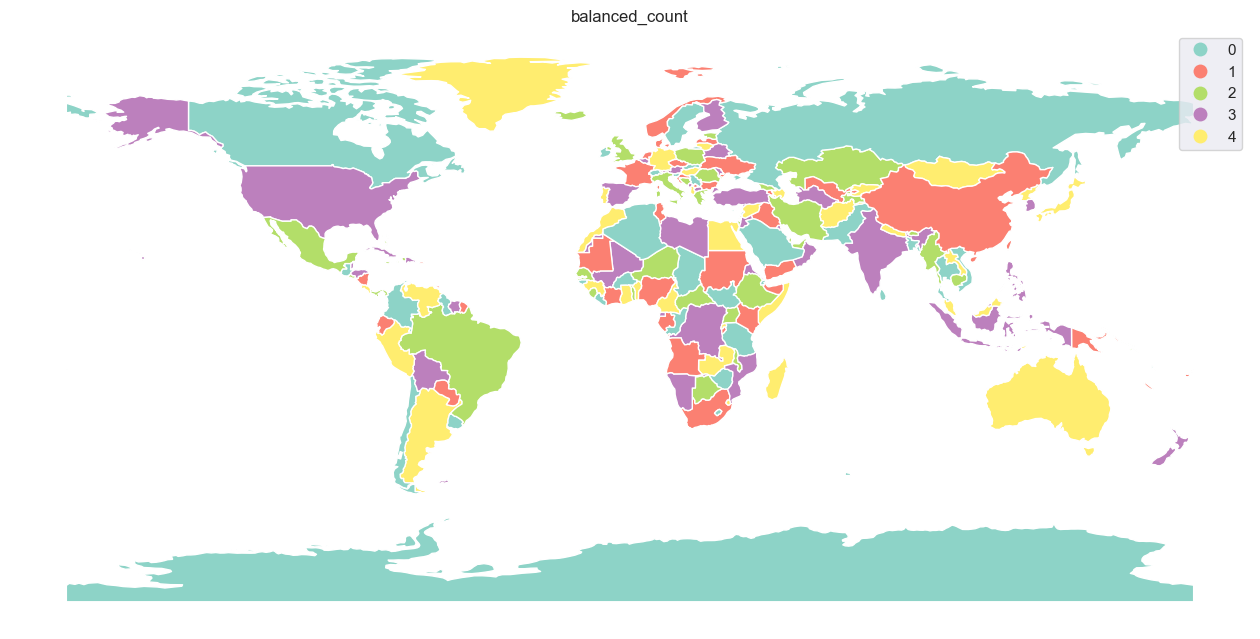

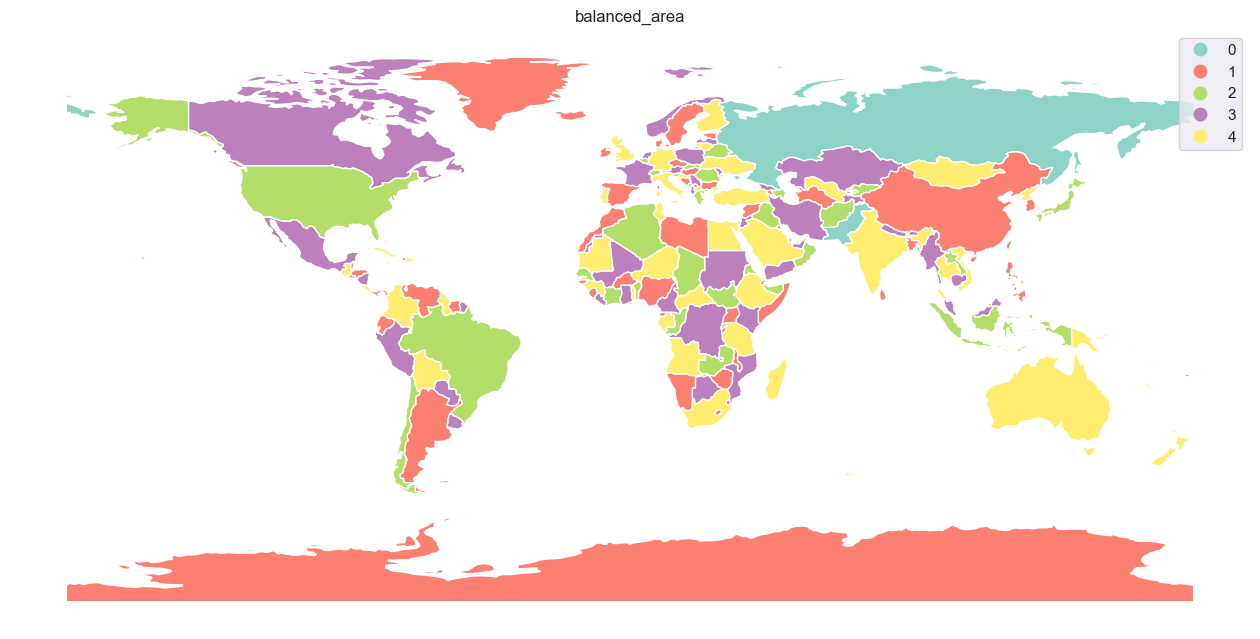

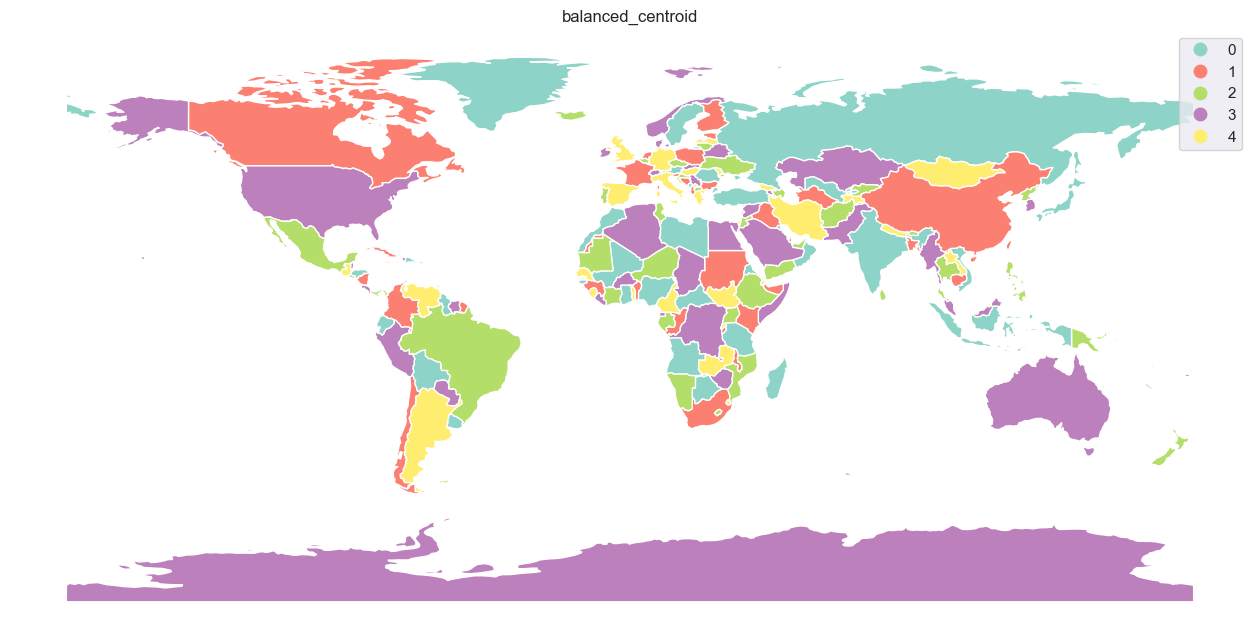

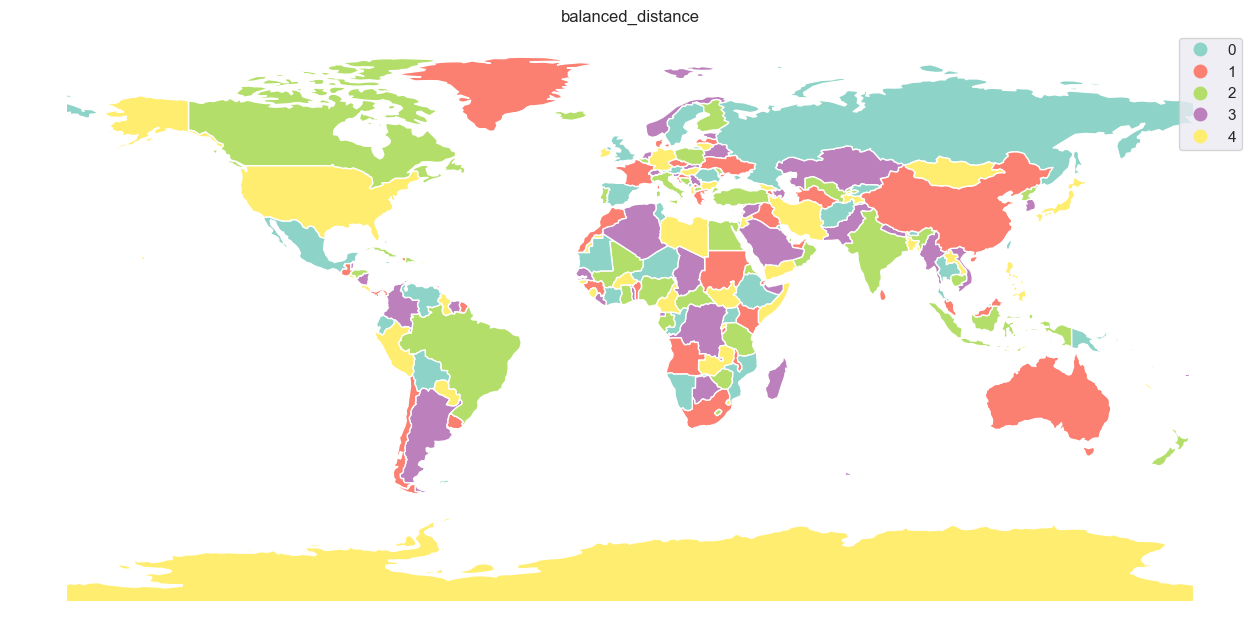

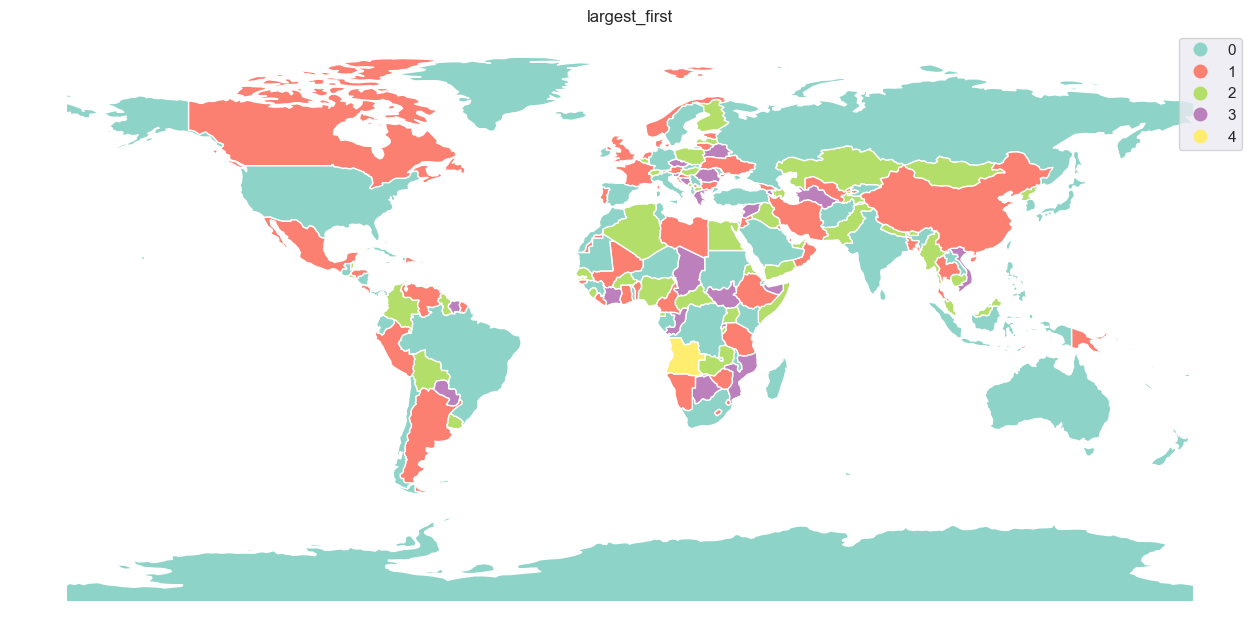

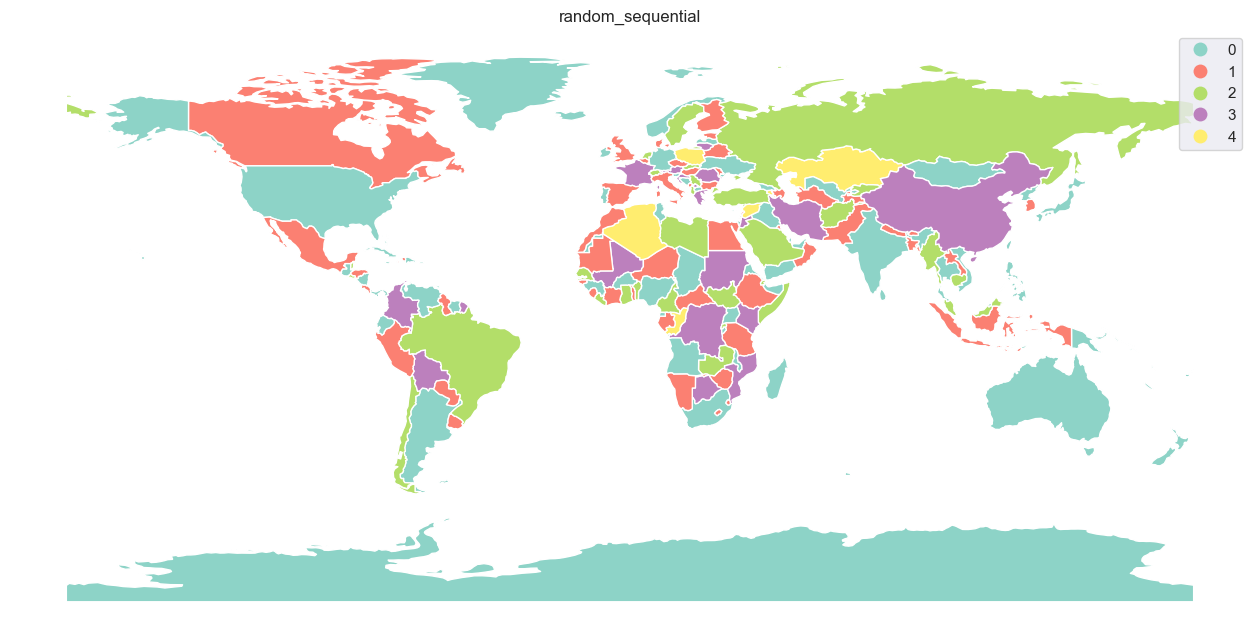

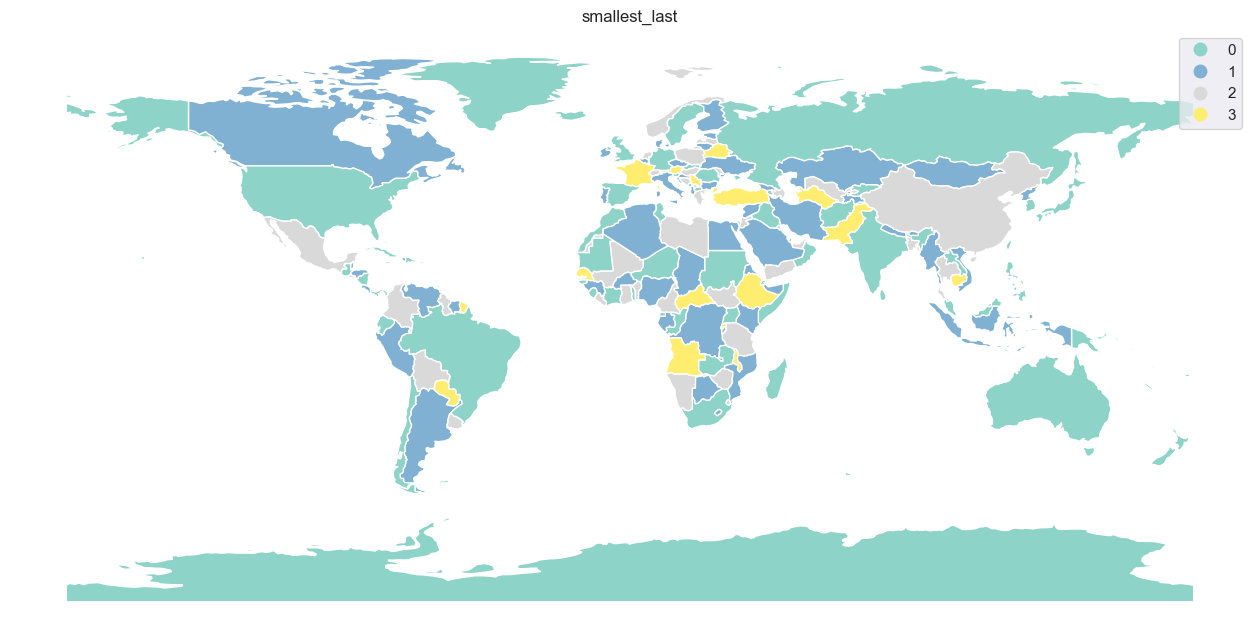

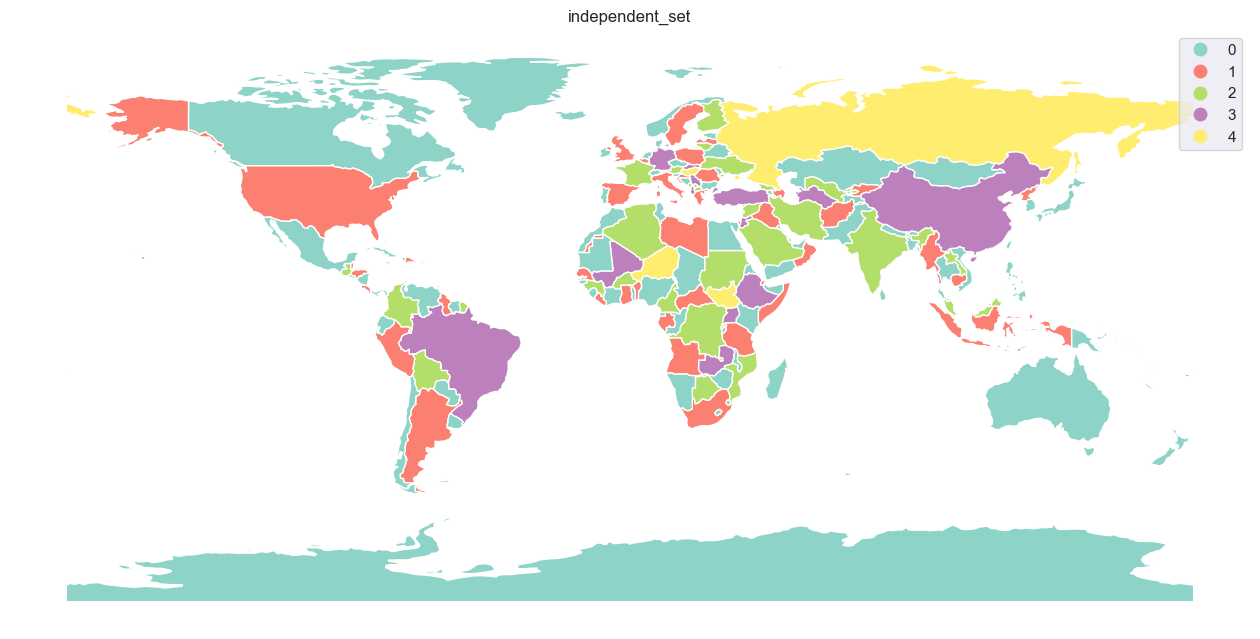

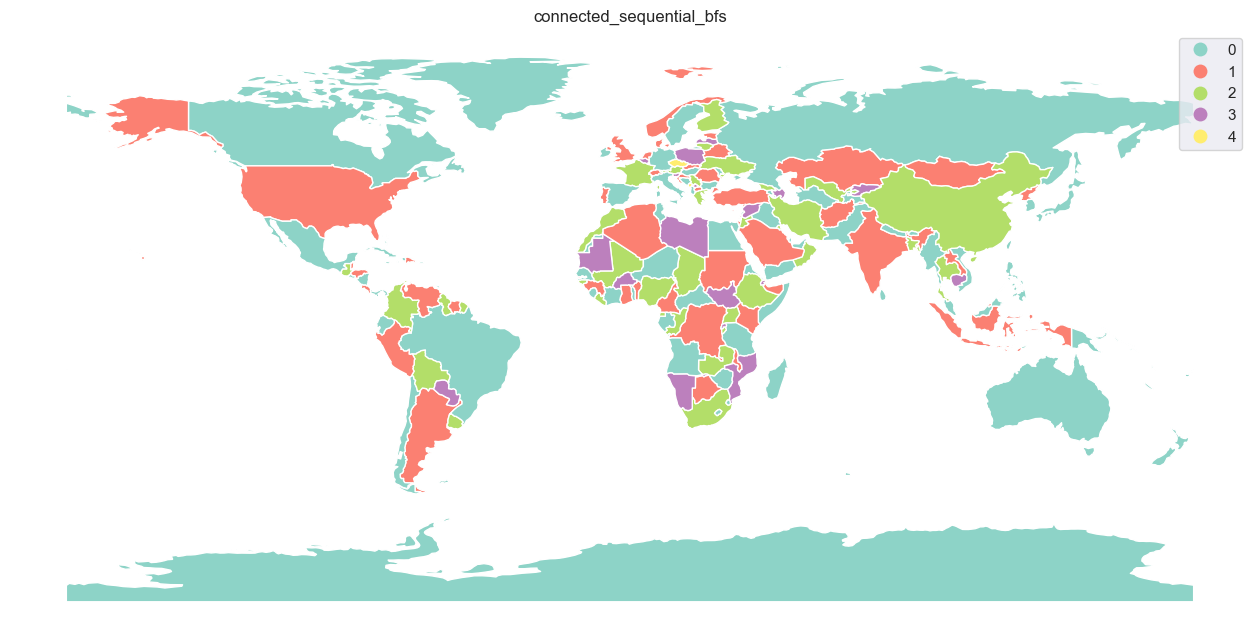

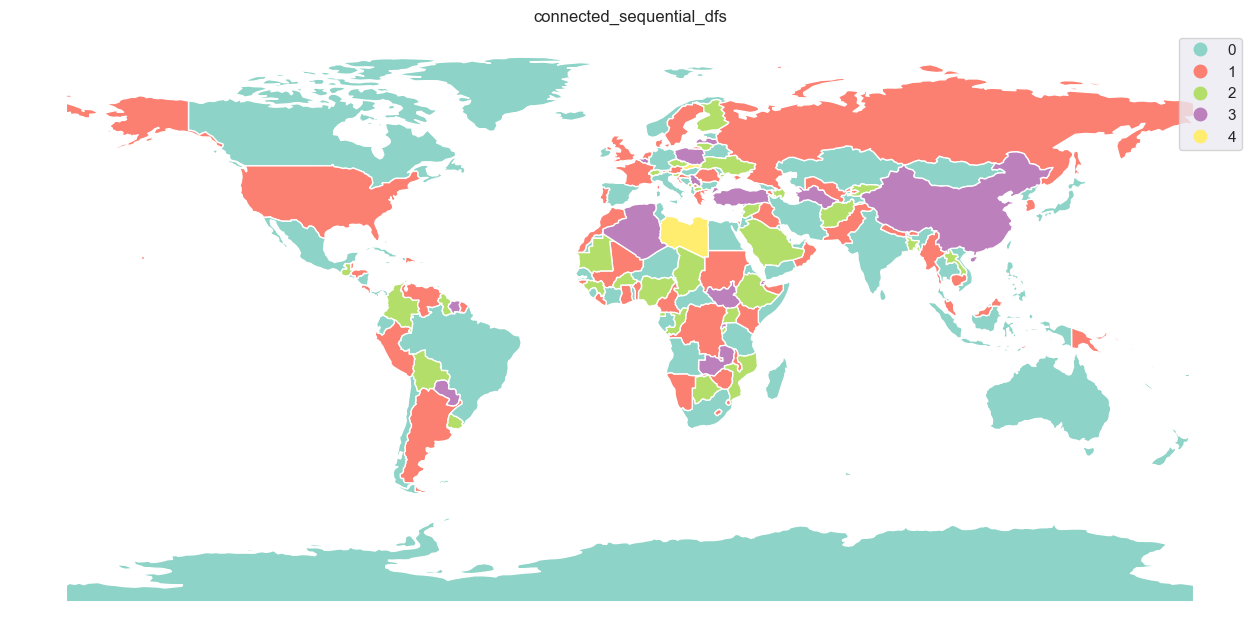

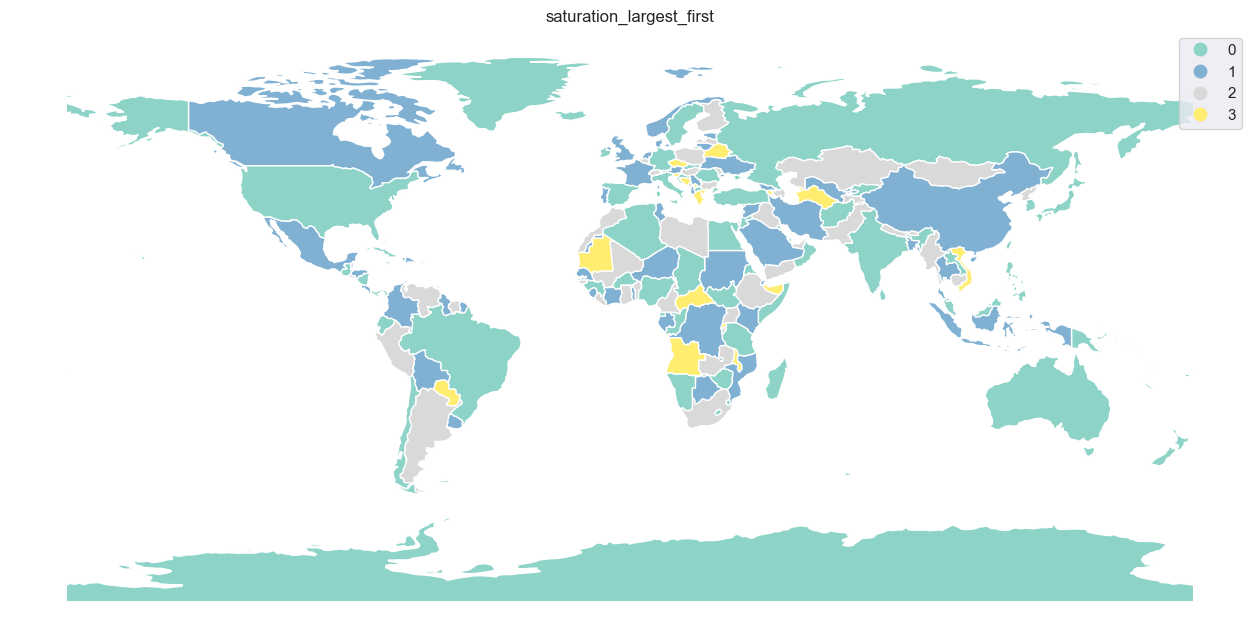

In [31]:
plt_kws = {"categorical": True, "figsize": (16, 12), "cmap": "Set3", "legend": True}
for strategy in times.index:
    ax = world.plot(strategy, **plt_kws)
    ax.set_axis_off()
    ax.set_title(strategy)

------------------------------